# FishNet Dataset Overview

This notebook analyzes the FishNet dataset structure and provides statistics on class distribution, sample counts, and data balance.

In [4]:
import json
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Dataset Metadata

First, let's load the metadata from the extracted features to understand our dataset composition.

In [5]:
# Load metadata from extracted features
metadata_path = Path('../artifacts/fishnet/features/metadata.json')

if metadata_path.exists():
    with open(metadata_path) as f:
        metadata = json.load(f)
    
    print(f"Dataset root: {metadata['dataset_root']}")
    print(f"Number of classes: {len(metadata['classes'])}")
    print(f"Feature extractor: {metadata['hub_name']}")
    print(f"\nSplits:")
    for split_name, split_info in metadata['splits'].items():
        print(f"  {split_name}: {split_info['count']} samples")
else:
    print("Metadata not found. Please run feature extraction first.")
    metadata = None

Dataset root: /data/home/bowen/projects/dino/dinov3/datasets/fishnet
Number of classes: 570
Feature extractor: dinov3_vits16

Splits:
  train: 66365 samples
  val: 14220 samples
  test: 14220 samples


## 2. Scan Dataset Directory

Count samples per class directly from the filesystem.

In [6]:
# Scan the dataset directory
dataset_root = Path('../datasets/fishnet')

class_counts = {}
total_images = 0

if dataset_root.exists():
    # Count images per class
    for class_dir in sorted(dataset_root.iterdir()):
        if class_dir.is_dir():
            # Count image files (jpg, jpeg, png)
            image_files = list(class_dir.glob('*.jpg')) + \
                         list(class_dir.glob('*.jpeg')) + \
                         list(class_dir.glob('*.png')) + \
                         list(class_dir.glob('*.JPG')) + \
                         list(class_dir.glob('*.JPEG'))
            count = len(image_files)
            if count > 0:
                class_counts[class_dir.name] = count
                total_images += count
    
    print(f"Total classes: {len(class_counts)}")
    print(f"Total images: {total_images:,}")
    print(f"Average images per class: {total_images / len(class_counts):.1f}")
else:
    print(f"Dataset directory not found: {dataset_root}")

Total classes: 570
Total images: 94,805
Average images per class: 166.3


## 3. Class Distribution Statistics

In [7]:
# Create a DataFrame for easier analysis
df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['count'])
df.index.name = 'class_name'
df = df.sort_values('count', ascending=False)

# Summary statistics
print("=== Class Distribution Statistics ===\n")
print(f"Min samples per class: {df['count'].min()}")
print(f"Max samples per class: {df['count'].max()}")
print(f"Median samples per class: {df['count'].median():.0f}")
print(f"Mean samples per class: {df['count'].mean():.1f}")
print(f"Std dev: {df['count'].std():.1f}")

# Percentiles
print(f"\nPercentiles:")
for p in [10, 25, 50, 75, 90]:
    print(f"  {p}th percentile: {df['count'].quantile(p/100):.0f}")

# Classes with very few samples
print(f"\n=== Classes with < 50 samples ===")
rare_classes = df[df['count'] < 50]
print(f"Number of rare classes: {len(rare_classes)}")
if len(rare_classes) > 0:
    print(rare_classes.head(10))

=== Class Distribution Statistics ===

Min samples per class: 1
Max samples per class: 5978
Median samples per class: 20
Mean samples per class: 166.3
Std dev: 508.8

Percentiles:
  10th percentile: 2
  25th percentile: 6
  50th percentile: 20
  75th percentile: 82
  90th percentile: 341

=== Classes with < 50 samples ===
Number of rare classes: 391
                   count
class_name              
Terapontidae          49
Anabantidae           49
Akysidae              49
Badidae               48
Crenuchidae           48
Atherinidae           47
Atherinopsidae        46
Lophiidae             46
Chimaeridae           46
Pseudopimelodidae     44


## 4. Visualize Class Distribution

### 4.1 Top 30 Most Common Classes

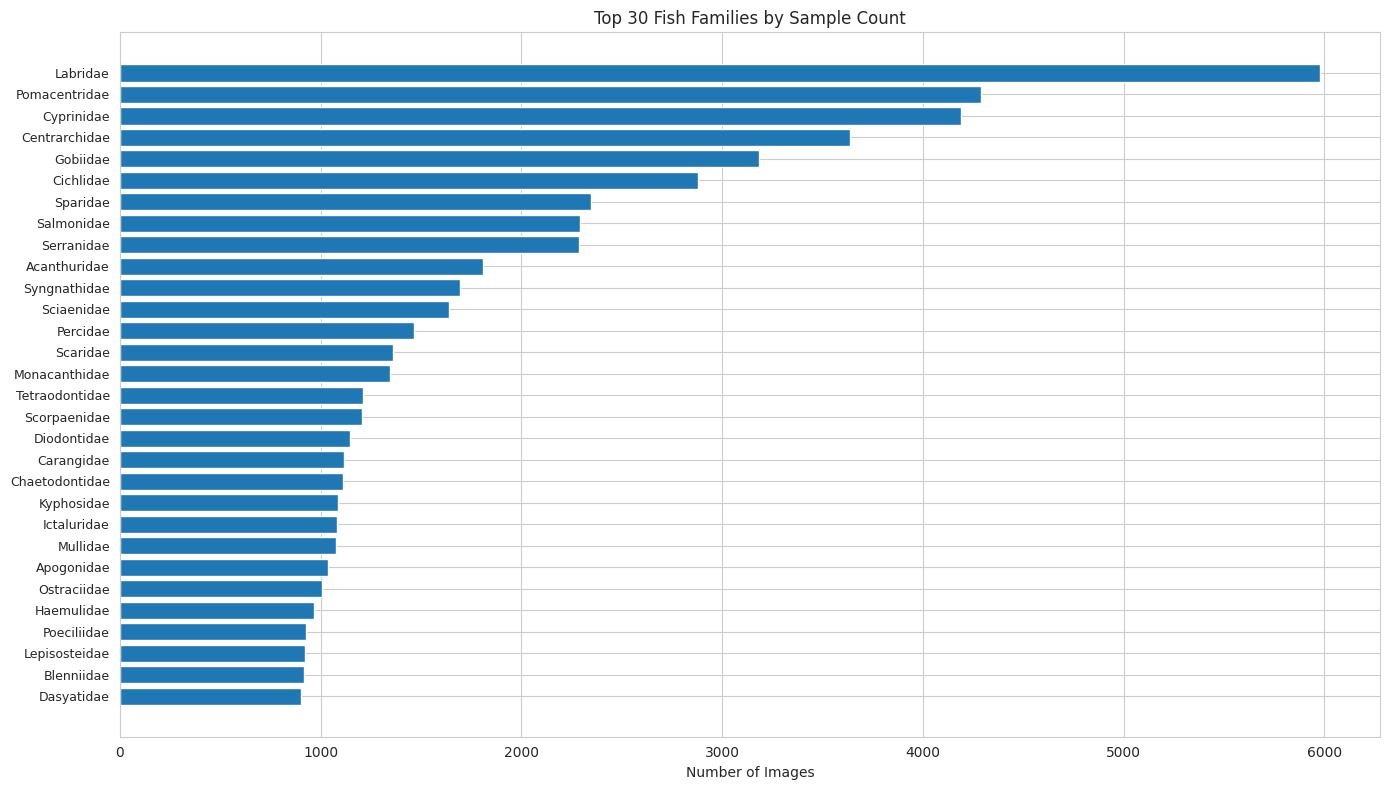

In [8]:
plt.figure(figsize=(14, 8))
top_30 = df.head(30)
plt.barh(range(len(top_30)), top_30['count'])
plt.yticks(range(len(top_30)), top_30.index, fontsize=9)
plt.xlabel('Number of Images')
plt.title('Top 30 Fish Families by Sample Count')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 4.2 Sample Count Distribution (Histogram)

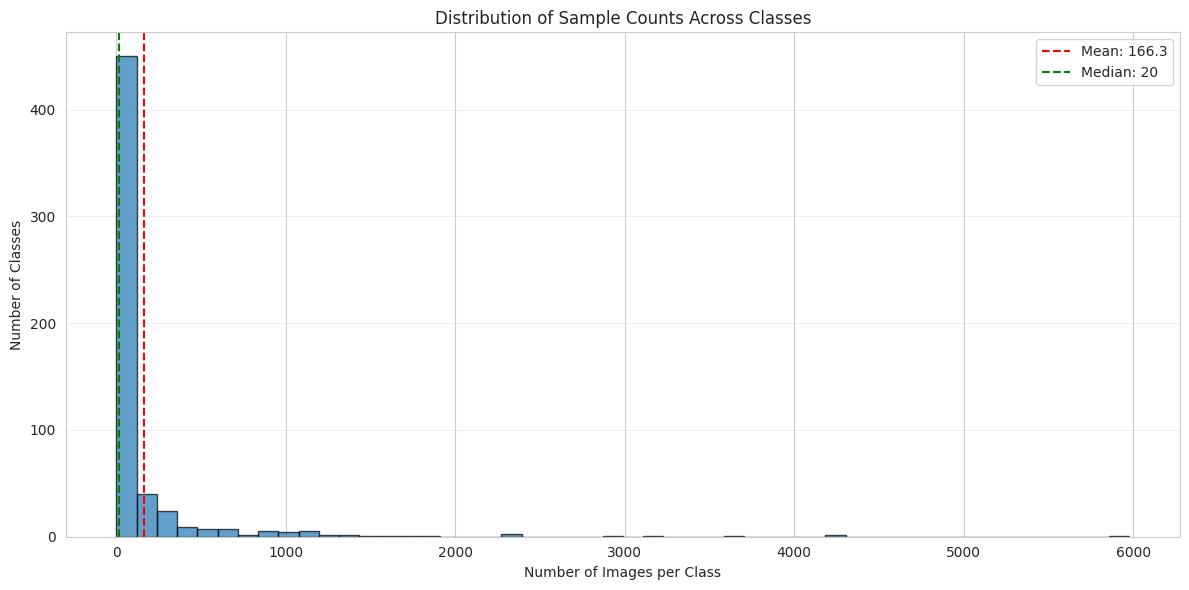

In [9]:
plt.figure(figsize=(12, 6))
plt.hist(df['count'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Images per Class')
plt.ylabel('Number of Classes')
plt.title('Distribution of Sample Counts Across Classes')
plt.axvline(df['count'].mean(), color='r', linestyle='--', label=f'Mean: {df["count"].mean():.1f}')
plt.axvline(df['count'].median(), color='g', linestyle='--', label=f'Median: {df["count"].median():.0f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 4.3 Cumulative Distribution

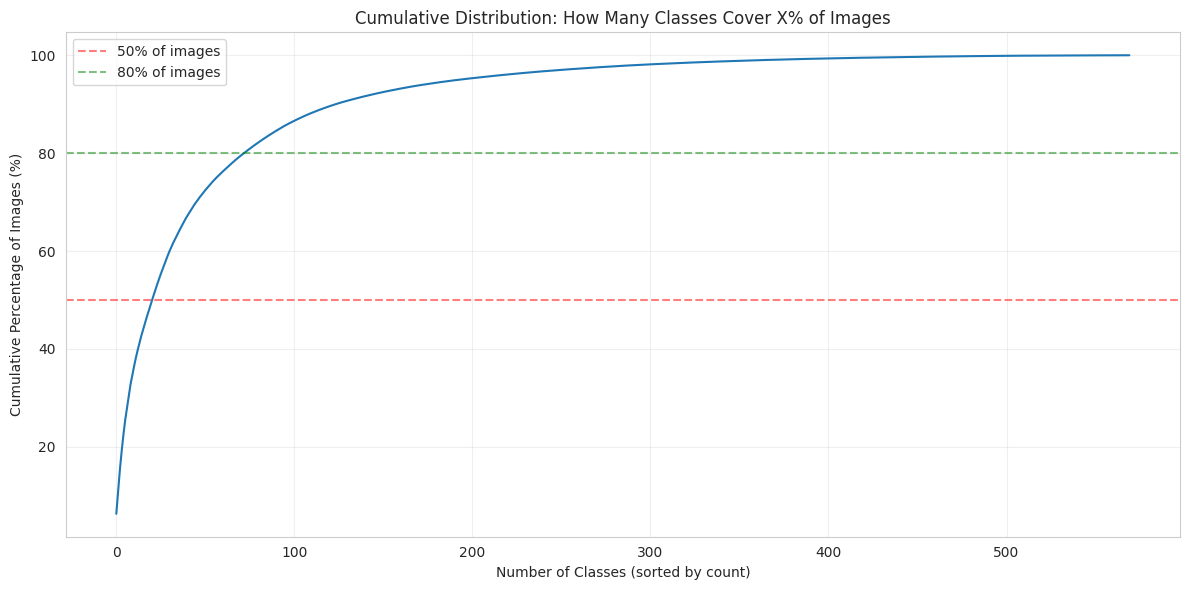


Top 21 classes contain 50% of all images
Top 72 classes contain 80% of all images


In [10]:
# Cumulative percentage of images
df_sorted = df.sort_values('count', ascending=False)
df_sorted['cumulative_pct'] = df_sorted['count'].cumsum() / df_sorted['count'].sum() * 100

plt.figure(figsize=(12, 6))
plt.plot(range(len(df_sorted)), df_sorted['cumulative_pct'])
plt.xlabel('Number of Classes (sorted by count)')
plt.ylabel('Cumulative Percentage of Images (%)')
plt.title('Cumulative Distribution: How Many Classes Cover X% of Images')
plt.grid(True, alpha=0.3)
plt.axhline(50, color='r', linestyle='--', alpha=0.5, label='50% of images')
plt.axhline(80, color='g', linestyle='--', alpha=0.5, label='80% of images')
plt.legend()
plt.tight_layout()
plt.show()

# Print insights
classes_for_50 = (df_sorted['cumulative_pct'] <= 50).sum()
classes_for_80 = (df_sorted['cumulative_pct'] <= 80).sum()
print(f"\nTop {classes_for_50} classes contain 50% of all images")
print(f"Top {classes_for_80} classes contain 80% of all images")

## 5. Class Imbalance Analysis

=== Class Imbalance Metrics ===

Imbalance ratio (max/min): 5978.0:1
Most common class: Labridae (5978 images)
Least common class: Anchariidae (1 images)

=== Class Size Distribution ===
size_category
Very Small (<50)     391
Small (50-100)        52
Medium (100-200)      33
Large (200-500)       49
Very Large (>500)     45
Name: count, dtype: int64


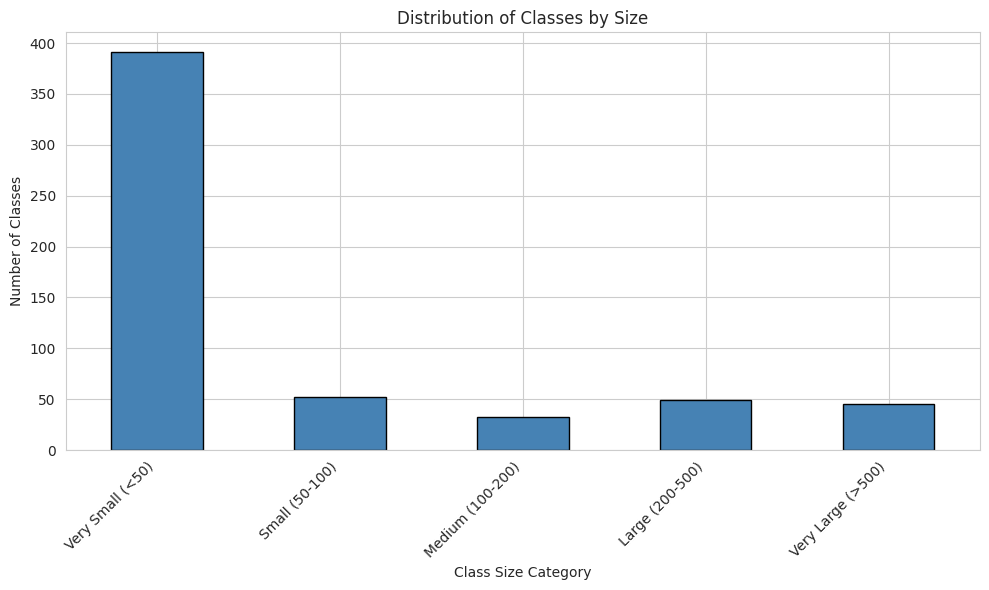

In [11]:
# Calculate imbalance ratio
max_count = df['count'].max()
min_count = df['count'].min()
imbalance_ratio = max_count / min_count

print(f"=== Class Imbalance Metrics ===\n")
print(f"Imbalance ratio (max/min): {imbalance_ratio:.1f}:1")
print(f"Most common class: {df.idxmax()['count']} ({max_count} images)")
print(f"Least common class: {df.idxmin()['count']} ({min_count} images)")

# Categorize classes by size
bins = [0, 50, 100, 200, 500, float('inf')]
labels = ['Very Small (<50)', 'Small (50-100)', 'Medium (100-200)', 'Large (200-500)', 'Very Large (>500)']
df['size_category'] = pd.cut(df['count'], bins=bins, labels=labels)

print(f"\n=== Class Size Distribution ===")
print(df['size_category'].value_counts().sort_index())

# Visualize
plt.figure(figsize=(10, 6))
df['size_category'].value_counts().sort_index().plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Class Size Category')
plt.ylabel('Number of Classes')
plt.title('Distribution of Classes by Size')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 6. Train/Val/Test Split Analysis

If features have been extracted with splits, analyze the distribution.

=== Split Distribution ===

train     : 66,365 images (70.00%)
val       : 14,220 images (15.00%)
test      : 14,220 images (15.00%)


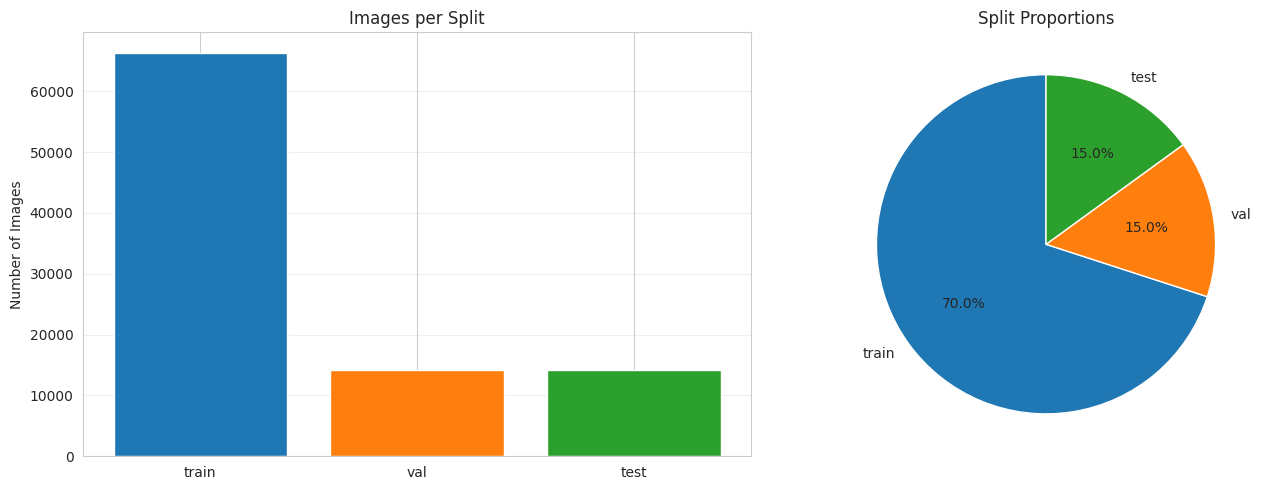

In [12]:
if metadata and 'splits' in metadata:
    splits = metadata['splits']
    
    # Create split summary
    split_data = {split: info['count'] for split, info in splits.items()}
    total = sum(split_data.values())
    
    print("=== Split Distribution ===\n")
    for split, count in split_data.items():
        pct = count / total * 100
        print(f"{split:10s}: {count:6,} images ({pct:5.2f}%)")
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart
    ax1.bar(split_data.keys(), split_data.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax1.set_ylabel('Number of Images')
    ax1.set_title('Images per Split')
    ax1.grid(axis='y', alpha=0.3)
    
    # Pie chart
    ax2.pie(split_data.values(), labels=split_data.keys(), autopct='%1.1f%%', startangle=90,
            colors=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax2.set_title('Split Proportions')
    
    plt.tight_layout()
    plt.show()
else:
    print("Split information not available in metadata.")

## 7. Summary and Recommendations

In [13]:
print("=" * 60)
print("DATASET SUMMARY")
print("=" * 60)
print(f"\n📊 Overall Statistics:")
print(f"   • Total fish families: {len(class_counts)}")
print(f"   • Total images: {total_images:,}")
print(f"   • Average per class: {total_images / len(class_counts):.1f}")
print(f"   • Imbalance ratio: {imbalance_ratio:.1f}:1")

print(f"\n📈 Class Size Distribution:")
very_small = len(df[df['count'] < 50])
small = len(df[(df['count'] >= 50) & (df['count'] < 100)])
medium = len(df[(df['count'] >= 100) & (df['count'] < 200)])
large = len(df[(df['count'] >= 200) & (df['count'] < 500)])
very_large = len(df[df['count'] >= 500])

print(f"   • Very Small (<50):    {very_small:3d} classes ({very_small/len(df)*100:.1f}%)")
print(f"   • Small (50-100):      {small:3d} classes ({small/len(df)*100:.1f}%)")
print(f"   • Medium (100-200):    {medium:3d} classes ({medium/len(df)*100:.1f}%)")
print(f"   • Large (200-500):     {large:3d} classes ({large/len(df)*100:.1f}%)")
print(f"   • Very Large (>500):   {very_large:3d} classes ({very_large/len(df)*100:.1f}%)")

print(f"\n💡 Recommendations:")
if very_small > len(df) * 0.1:
    print(f"   ⚠️  {very_small} classes have <50 images - consider filtering or augmentation")
if imbalance_ratio > 100:
    print(f"   ⚠️  High class imbalance detected - use --class-weighting balanced")
else:
    print(f"   ✅ Class imbalance is manageable with balanced weighting")

print(f"   ✅ Use --standardize for better convergence")
print(f"   ✅ Consider --hidden-dim 2048-4096 for this dataset size")
print(f"   ✅ Monitor per-class metrics for rare species")
print("=" * 60)

DATASET SUMMARY

📊 Overall Statistics:
   • Total fish families: 570
   • Total images: 94,805
   • Average per class: 166.3
   • Imbalance ratio: 5978.0:1

📈 Class Size Distribution:
   • Very Small (<50):    391 classes (68.6%)
   • Small (50-100):       50 classes (8.8%)
   • Medium (100-200):     35 classes (6.1%)
   • Large (200-500):      49 classes (8.6%)
   • Very Large (>500):    45 classes (7.9%)

💡 Recommendations:
   ⚠️  391 classes have <50 images - consider filtering or augmentation
   ⚠️  High class imbalance detected - use --class-weighting balanced
   ✅ Use --standardize for better convergence
   ✅ Consider --hidden-dim 2048-4096 for this dataset size
   ✅ Monitor per-class metrics for rare species
